---
## Linear Regression with Tensorboard.
---
__Introduction to Tensorboard__

Training & optimizing neural networks can be an iterative process. To provide better insight about how well the model is getting trained, Tensorflow has a visualization tool called Tensorboard [[1]](https://www.tensorflow.org/get_started/summaries_and_tensorboard). Tensorboard is an easy way to visualize all the the standard graphs from your training loss to how the weights are being updated.

![Tensorboard](https://www.tensorflow.org/images/mnist_tensorboard.png)

This section shows an example of how visualize `w` (from linear regression) in Tensorboard.

In [1]:
import time
from IPython import display

# Import the libraries and load the datasets.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import numpy as np
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

# Plots.
import matplotlib.pyplot as plt

Using TensorFlow backend.


---
### Linear Regression in Tensorflow
Following are the steps to implement a simple linear regression function in Tensorflow.

_Example: Consider the line `y = 12 * x + 10`_

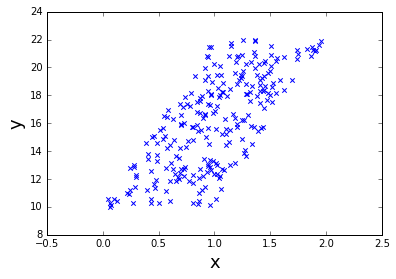

In [2]:
# Generate some random data.
n = 250 # Number of datapoints.
d = 1 # The dimensions of the datapoints.
slope = 12
bias = 10

# Randomly generate input.
sample_x = np.random.rand(n, d)

# Consider the equation of the y = m.x + b
sample_y = slope*sample_x + bias

# NOTE: We do not want a straight line. So add some random noise to the input.
sample_noise = np.random.rand(n, d)
sample_x += sample_noise

# Plot.
plt.scatter(sample_x, sample_y, marker='x')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

---
### Scopes, Summaries & Histograms.
All the operations performed in the previous and current tutorial (including variables and constants) are given __variable names__ by Tensorflow, while compiling the computation graph. An example is `'Const', 'Const_1'` that is the name for two constants. This is in case the name has not been provided while performing the operation or creating the variable (the name can be provided using the `name` parameter in operation / variable).

__NOTE: In case the name is provided, it is the developer's responsibility to keep them unique!__

Tensorflow, also gives developers a method to change the scope of the names by using `tf.name_scope` where the name entered is attached as __prefix__ to all the variables in that scope. It makes it easy to track output of varies operations / variables while the training or testing.

In our current example, `name_scope` is not necessary as we have just $2$ variables.

In [3]:
# NOTE: The name of the variable is optional.
x = tf.placeholder(tf.float32, shape=(None, 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="Y")
lr_rate = tf.placeholder(tf.float32, shape=(), name="lr")

# Weight & bias.
# w = tf.get_variable(shape=[1], name="w", initializer=tf.zeros_initializer())
# b = tf.get_variable(shape=[1], name="b", initializer=tf.zeros_initializer())

# Initialize with a different value.
w = tf.Variable(np.array([[5.0]]), dtype=tf.float32, name="w")
b = tf.Variable(np.array([[5.0]]), dtype=tf.float32, name="b")

with tf.name_scope("weights"):
    w_temp = tf.Variable(np.array([[5.0]]), dtype=tf.float32, name="w")
    b_temp = tf.Variable(np.array([[5.0]]), dtype=tf.float32, name="b")
    

# Note the difference in how the names are!
print("Without Scope: {}".format(w.name))
print("Without Scope: {}".format(w_temp.name))

Without Scope: w:0
Without Scope: weights/w:0


__Step 2__: Once the placeholders & variable have been created, compute the $y$.

In [4]:
# Compute predicted Y.
y_pred = w*x + b

__Step 3__: Once the predicted $y$ has been computed, define the loss between the predicted $y$ and the actual $y$.

The loss can be of various forms. In case of linear regression, we can use the L2-norm or the euclidean distance between the two points.

$Loss(y) = \lVert y - y_{pred} \rVert^2$   

i.e.  

$Loss(y) = \frac{\sum_n(y - y_{pred})^2}{2*n}$

In [5]:
loss = tf.div(tf.reduce_mean(tf.square(y - y_pred)), 2*n)

# This can be done in a single line.
# loss = tf.losses.mean_squared_error(y, y_pred)

__Step 4__: The loss shows how far we are from the actual $y$ value. Use the loss to change the weights by calulating the gradient w.r.t $w$. We use a stochastic gradient descent optimizer for this purpose.

In [6]:
# Create a gradient descent optimizer with the set learning rate
optimizer = tf.train.GradientDescentOptimizer(learning_rate=lr_rate)

# Run the optimizer to minimize loss
# Tensorflow automatically computes the gradients for the loss function!!!
train = optimizer.minimize(loss)

`tf.summary` contains a set of operations that allow model information to be exported to a readable format, so that it can be visualized by tools such as Tensorboard. The common methods that are used are:
* `tf.summary.scalar`: Contains the summary of a Tensor.
* `tf.summary.histogram`: Create a histogram for the Tensor.
* `tf.summary.merge`: Merge the summaries of a given set of Tensors.
* `tf.summary.mergeall`: Merge all the summaries in the given Tensor graph.

__Step 5__: Add summaries for the variables that are to be visualized.

In [7]:
# Helper function.
# https://www.tensorflow.org/get_started/summaries_and_tensorboard
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope(name):
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
            
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)
    
# Define summaries.
variable_summaries(w, "weights")
variable_summaries(b, "bias")
variable_summaries(loss, "loss")

__Step 6__: `train` the model.

In [8]:
# Initialize all variables
init = tf.global_variables_initializer()

__Step 7__: With the histogram being generated for each variable. `merge_all` the summaries.
The logs are written to the `logs/` which is the logs sub-directory from the current.

W: 7.73510742188, B: 8.15111351013, Loss: 0.0123884677887
Slope: 12, Bias: 10


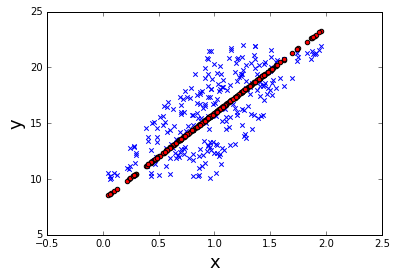

In [9]:
# Define some hyper-parameters.
lr = 0.1
epochs = 5000
log_dir = 'logs/tf/' # Tensorboard log directory.

# Train the model.
with tf.Session() as sess:
    # Initialize all variables
    sess.run(init)
    
    # Create the writer.
    # Merge all the summaries and write them.
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(log_dir, sess.graph)
    
    for epoch in range(epochs):
        y_p, curr_w, curr_b, curr_loss, _, summary = sess.run([y_pred, w, b, loss,
                                                               train, merged],
                                                      feed_dict = {x:sample_x, y: sample_y,
                                                                  lr_rate: lr})
        # IMP: Add the summary for each epoch.
        train_writer.add_summary(summary, epoch)    
    
    train_writer.close() # <-------Important!
    print("W: {}, B: {}, Loss: {}".format(curr_w[0][0], curr_b[0][0], curr_loss))
    print("Slope: {}, Bias: {}".format(slope, bias))
    plt.scatter(sample_x, sample_y, marker='x')
    plt.scatter(sample_x, y_p, c='red', marker='o')
    plt.xlabel('x', fontsize=18)
    plt.ylabel('y', fontsize=18)
    plt.show()

---
## Keras Implementation.
Similar to the example in linear regression, Keras makes it __easy__ to generate summaries so that it can be visualized in Tensorboard.

In [10]:
from keras.layers import Dense, Input
from keras.initializers import random_normal
from keras.models import Model
from keras import optimizers, metrics

For tensorboard add it from __keras backend__. `keras.callbacks.TensorBoard`

In [11]:
from keras.callbacks import TensorBoard

In [12]:
# Create a layer to take an input.
input_l = Input(shape=np.array([1]))
# Compute Wx + b.
dense = Dense(np.array([1]), activation='linear')
output = dense(input_l)

In [13]:
# Create a model and compile it.
model = Model(inputs=[input_l], outputs=[output])
model.summary() # Get the summary.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, array([1]))        2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [14]:
sgd = optimizers.sgd(lr=lr)
model.compile(optimizer=sgd, loss='mean_squared_error')

# NOTE: Add Tensorboard after compiling.
tensorboard = TensorBoard(log_dir="logs/keras/")

__That's pretty much it!__
Add `callbacks=[tensorboard]` to the fit function.

In [15]:
# Train the model.
# Add a callback.
model.fit(x=sample_x, y=sample_y, epochs=epochs, verbose=0, callbacks=[tensorboard])

In [16]:
# Predict the y's.
y_p = model.predict(sample_x)
y_p_loss = model.evaluate(sample_x, sample_y)

 32/250 [==>...........................] - ETA: 0s

Evaluation Metrics: ['loss']
W: 6.06071662903, B: 10.2424144745, Loss: 5.655091362
Slope: 12, Bias: 10


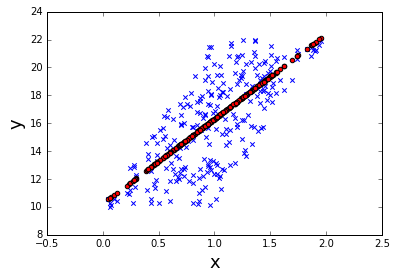

In [17]:
# Plot them.
print("Evaluation Metrics: " + str(model.metrics_names))
print("W: {}, B: {}, Loss: {}".format(dense.get_weights()[0][0][0],
                                      dense.get_weights()[1][0], y_p_loss))
print("Slope: {}, Bias: {}".format(slope, bias))
plt.scatter(sample_x, sample_y, marker='x')
plt.scatter(sample_x, y_p, c='red', marker='o')
plt.xlabel('x', fontsize=18)
plt.ylabel('y', fontsize=18)
plt.show()

__That's an example with TensorBoard!__

Tensorboard command: `$> tensorboard --logdir <log directory>`